In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from astropy.table import Table
import pandas as pd
import re
import sys
import glob
from astropy.coordinates import SkyCoord
from astropy import units as u
from sklearn.neighbors import KDTree

%matplotlib inline
sb.set(style="ticks", color_codes=True, context="poster")

mainpath = '/Users/jorgetil/Astro/HITS'

In [2]:
def rms(x):
    return np.sqrt(x.dot(x)/x.size)

def MAD(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

def mask_ratio(x, y, n=3.):
    ratio = x / y
    ratio_MAD = MAD(ratio)
    mask = (ratio > np.median(ratio) - n * ratio_MAD) & \
           (ratio < np.median(ratio) + n * ratio_MAD)
    return mask

def mask_diff(x, y, n=3.):
    diff = x - y
    diff_MAD = MAD(diff)
    mask = (diff > np.median(diff) - n * diff_MAD) & \
           (diff < np.median(diff) + n * diff_MAD)
    return mask

In [13]:
field = 'Blind15A_25'
N_cd = 3
EXP_TIME = 86
CCDID = 13
ccds[N_cd]

'N4'

In [14]:
DECam_path = '%s/PhotometricCal_DECam/psmFitDES-mean-r.csv' % (mainpath)
DECam = np.loadtxt(DECam_path, delimiter = ',', skiprows = 1,
                   usecols = [4,5,6,7,8,9,10,11,19], dtype = str)

Ag = float(DECam[CCDID-1][2])
err_Ag = float(DECam[CCDID-1][3])
Kg = float(DECam[CCDID-1][6])
err_Kg = float(DECam[CCDID-1][7])
bg = float(DECam[CCDID-1][4])
err_bg = float(DECam[CCDID-1][4])
g_r0 = float(DECam[CCDID-1][8])

In [15]:
print err_Ag

0.023378


In [16]:
ccds_file = '%s/INFO/ccds.txt' % (mainpath)
ccds = np.loadtxt(ccds_file, comments = '#', dtype = str)

epochs_g_file = '%s/INFO/%s/%s_epochs_%s.txt' % (mainpath, field, field, 'r')
epochs_g = np.loadtxt(epochs_g_file, comments = '#', dtype = str)
print epochs_g

[['01' '57070.0717088']
 ['24' '57077.0421334']
 ['27' '57080.0467181']
 ['31' '57095.1162608']
 ['33' '57089.2280307']]


In [23]:
cata_epochs = []
afluxes = []
info = []
for epo in epochs_g:
    print epo
    
    path = '%s/INFO/%s/%s_%s_r.npy'\
    % (mainpath, field, field, epo[0])
    try:
        inf = np.load(path)
        info.append(inf)
    except:
        info.append(None)
        print 'epoch does not have info file' 
    
    path = '%s/catalogues/%s/%s/%s_%s_%s_image_crblaster_thresh1.0_minarea1_backsize64_zp.dat'\
    % (mainpath, field, ccds[N_cd], field, ccds[N_cd], epo[0])
    cata = Table.read(path, format='ascii').to_pandas()
    cata_epochs.append(cata)
    if epo[0] == '02':
        print 'epoch does not have aflux file' 
        afluxes.append([1,0])
        continue
    path = '%s/INFO/%s/%s/aflux_%s_%s_%s-01.npy'\
    % (mainpath, field, ccds[N_cd], field, ccds[N_cd], epo[0])
    try:
        aflux = np.load(path)
        afluxes.append(aflux)
    except:
        afluxes.append(None)
        print 'epoch does not have aflux file' 

['01' '57070.0717088']
epoch does not have info file
epoch does not have aflux file
['24' '57077.0421334']
epoch does not have info file
['27' '57080.0467181']
epoch does not have info file
['31' '57095.1162608']
epoch does not have info file
['33' '57089.2280307']
epoch does not have info file


In [18]:
print len(info)

5


In [19]:
print cata_epochs[2].columns.values

['NUMBER' 'X_IMAGE' 'Y_IMAGE' 'RA' 'DEC' 'FLUX_AUTO' 'FLUXERR_AUTO'
 'FLUXERR_AUTO_COR' 'MAG_AUTO' 'MAG_AUTO_ZAC' 'MAG_AUTO_ZACI' 'MAGERR_AUTO'
 'MAGERR_AUTO_ZAC' 'MAGERR_AUTO_ZACI' 'MAGERR_AUTO_ZACI_COR' 'FLUX_RADIUS'
 'FWHM_IMAGE' 'CLASS_STAR' 'ELONGATION' 'FLAGS' 'A_IMAGE' 'B_IMAGE'
 'THETA_IMAGE' 'KRON_RADIUS' 'MU_MAX']


### PS1

In [20]:
PS1_path = '%s/PanSTARRS/%s_PS1_%s.vot' % (mainpath, field, ccds[N_cd])
print PS1_path
PS1_data = Table.read(PS1_path)
PS1_data = PS1_data.to_pandas()

/Users/jorgetil/Astro/HITS/PanSTARRS/Blind15A_25_PS1_N4.vot


In [21]:
print 'Shape of PS1 DF', PS1_data.shape
PS1_data_good_g = PS1_data.query('rMeanKronMag > 0')
print 'Shape of PS1 g detections DF', PS1_data_good_g.shape
PS1_data_good_g.describe()

Shape of PS1 DF (3826, 58)
Shape of PS1 g detections DF (2282, 58)


,objID,raMean,raMeanErr,decMean,decMeanErr,nDetections,objInfoFlag,qualityFlag,ng,nr,...,zMeanApMagStd,yMeanPSFMag,yMeanPSFMagErr,yMeanPSFMagStd,yMeanKronMag,yMeanKronMagErr,yMeanKronMagStd,yMeanApMag,yMeanApMagErr,yMeanApMagStd
count,2.282000e+03,2282.000000,2282.000000,2282.000000,2282.000000,2282.000000,2.282000e+03,2282.000000,2282.000000,2282.000000,...,2282.000000,2282.000000,2282.000000,2282.000000,2282.000000,2282.000000,2282.000000,2282.000000,2282.000000,2282.000000
mean,1.104908e+17,147.622174,-0.377131,2.078205,-0.379204,25.881683,4.134792e+08,49.259422,2.687555,8.829974,...,-461.751240,-601.655994,-610.222702,-700.393306,-651.254690,-657.501194,-721.827459,-605.278060,-612.404471,-708.693477
std,1.126258e+14,0.090135,20.914050,0.093726,20.913889,24.764122,1.425776e+08,16.995015,3.763634,7.985520,...,498.281264,496.577777,487.215370,457.469901,482.663842,473.993116,447.459633,495.694435,486.721480,453.752092
min,1.102715e+17,147.434315,-999.000000,1.894580,-999.000000,2.000000,1.679278e+08,20.000000,0.000000,1.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,1.104015e+17,147.549617,0.017193,2.001661,0.016853,3.000000,3.104563e+08,37.000000,0.000000,2.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
50%,1.104915e+17,147.623016,0.042295,2.078591,0.041400,17.000000,4.365271e+08,52.000000,0.000000,5.000000,...,0.015669,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
75%,1.105815e+17,147.695640,0.089902,2.153028,0.088690,48.000000,4.449157e+08,53.000000,6.000000,16.000000,...,0.177916,18.797426,0.034221,0.034812,17.877900,0.032613,0.035360,18.437699,0.047517,0.041412
max,1.107115e+17,147.802011,3.371840,2.263633,1.215790,84.000000,1.443160e+09,172.000000,12.000000,28.000000,...,1.070010,20.451700,0.496685,0.991868,20.344700,0.332061,1.252960,22.702700,0.661668,1.307720


## ZP calculation

In [24]:
PS1_coord = SkyCoord(ra=PS1_data_good_g.raMean.values, 
                     dec=PS1_data_good_g.decMean.values, frame='icrs', unit=u.degree)

Epoch: 01
Epoch: 24
Number of matches wihitn 2 arcsec: 506


/Users/jorgetil/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


rel + PS: Zero point: 26.070502 +- 0.526168
Boost: Zero point: 26.073276 +- 0.049851
PS: Zero point: 25.980724 +- 0.526168
Boost: Zero point: 25.977459 +- 0.051304


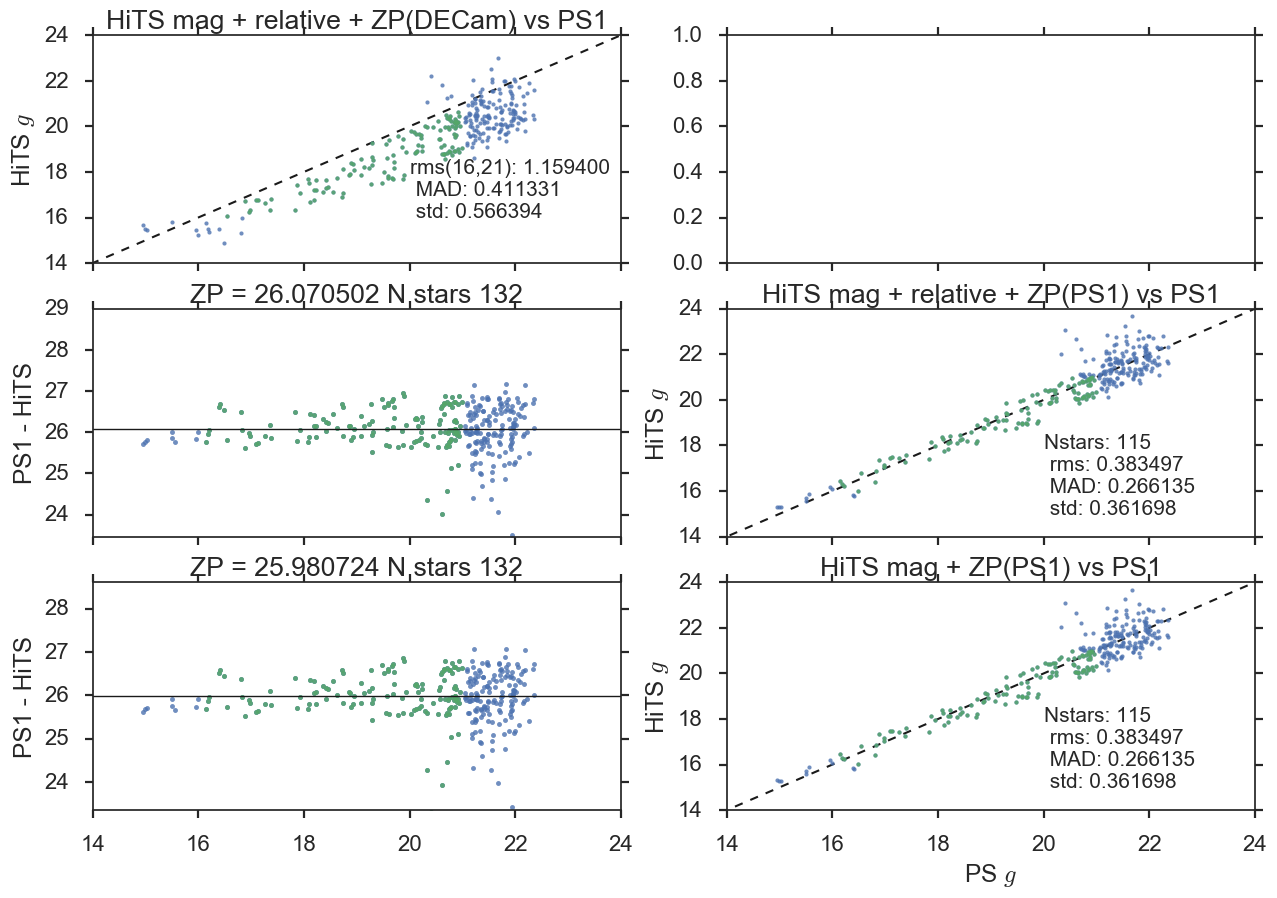

Epoch: 27
Number of matches wihitn 2 arcsec: 442
rel + PS: Zero point: 26.093235 +- 0.494440
Boost: Zero point: 26.093235 +- 0.047913
PS: Zero point: 26.062375 +- 0.494440
Boost: Zero point: 26.072936 +- 0.049800


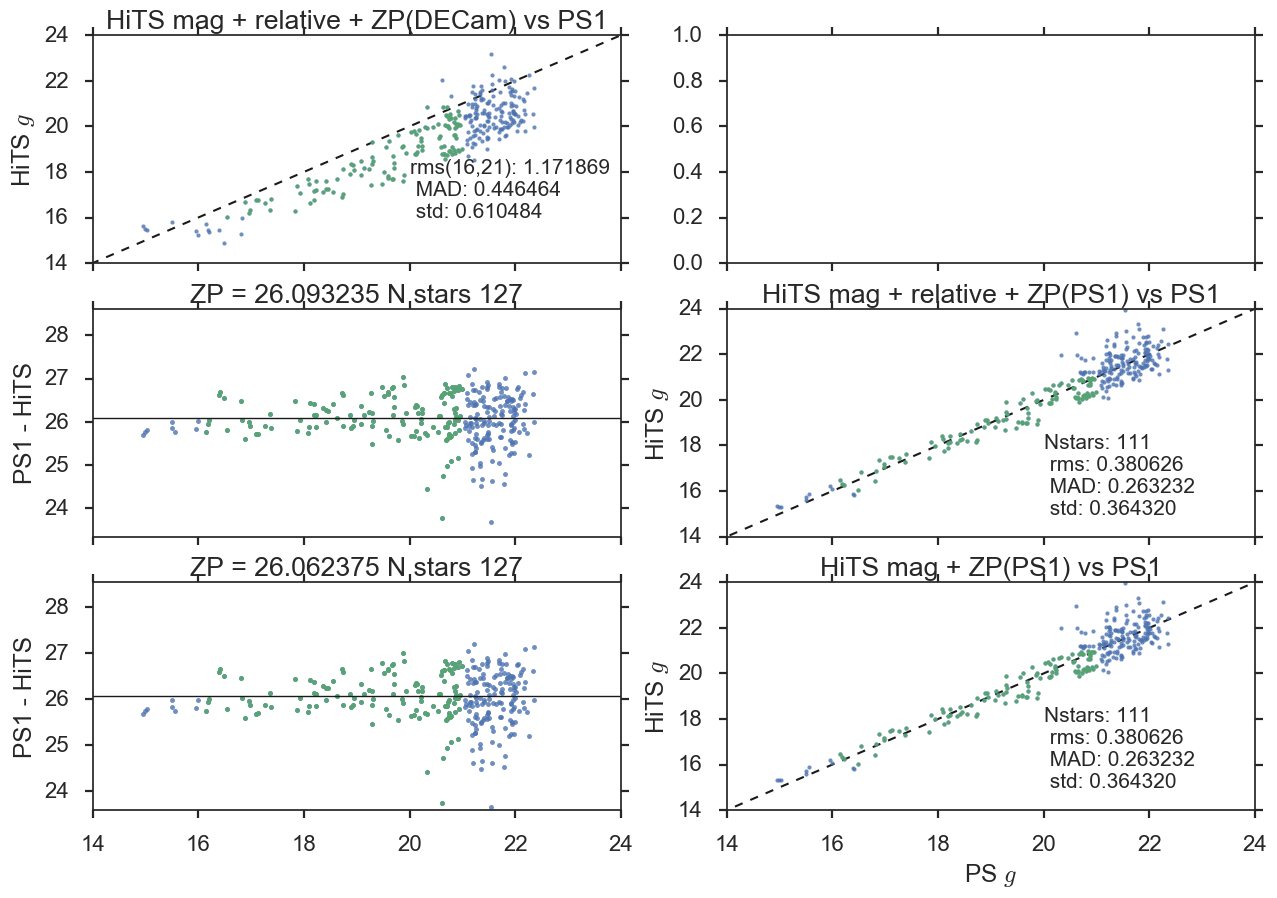

Epoch: 31
Number of matches wihitn 2 arcsec: 554
rel + PS: Zero point: 26.063190 +- 0.672162
Boost: Zero point: 26.048855 +- 0.055694
PS: Zero point: 26.061049 +- 0.672162
Boost: Zero point: 26.055732 +- 0.056271


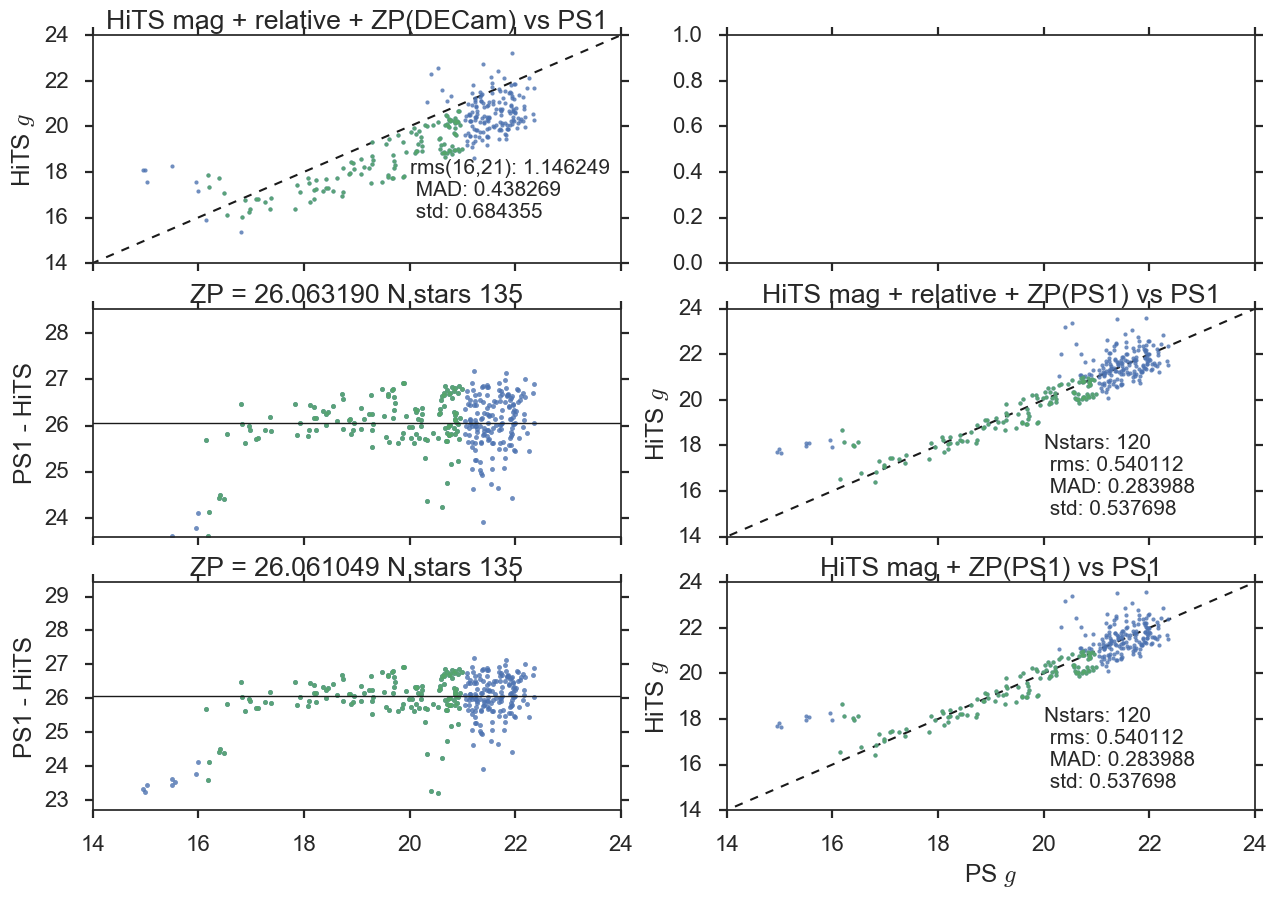

Epoch: 33
Number of matches wihitn 2 arcsec: 535
rel + PS: Zero point: 26.020818 +- 0.553318
Boost: Zero point: 26.020818 +- 0.056543
PS: Zero point: 26.229337 +- 0.553318
Boost: Zero point: 26.221905 +- 0.054960


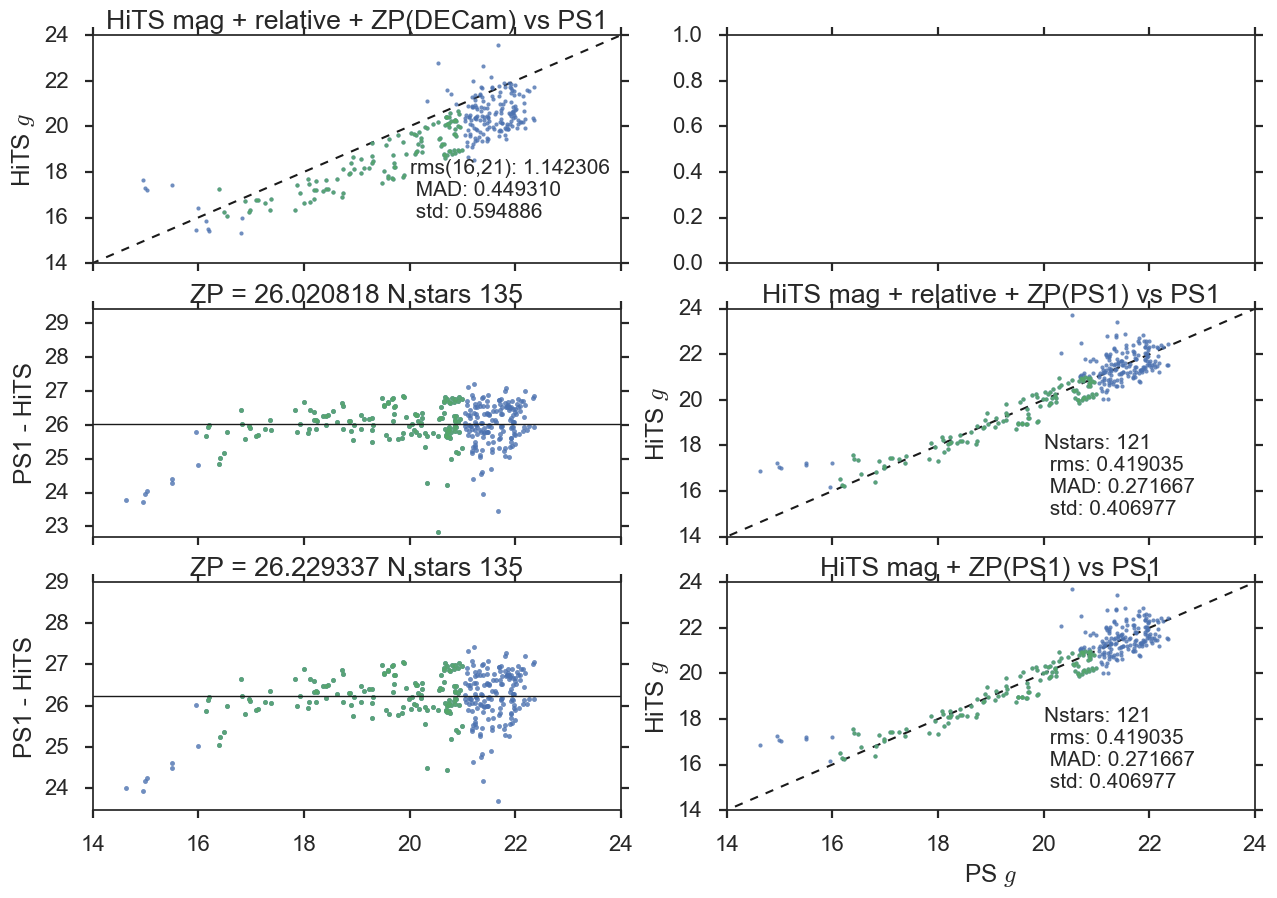

In [29]:
zp_rel_ps_all = []
zp_ps_all = []

for kk,epo in enumerate(epochs_g):
    print 'Epoch:',  epo[0]
    if afluxes[kk] == None:
        zp_rel_ps_all.append(None)
        zp_ps_all.append(None)
        continue
    HiTS_coord = SkyCoord(ra=cata_epochs[kk]['RA'].values, 
                     dec=cata_epochs[kk]['DEC'].values,
                    frame='icrs', unit=u.degree)
    idx, d2d, d3d = HiTS_coord.match_to_catalog_3d(PS1_coord)
    mask_less2 = (d2d.arcsec < 1.1)
    print 'Number of matches wihitn 2 arcsec:', len(idx[mask_less2])
    
    match_PS1 = PS1_data_good_g.iloc[idx[mask_less2]]
    match_HiTS = cata_epochs[kk].iloc[mask_less2]
    aflux = afluxes[kk][0]
    
    ##################################################################
    # Option 1a
    ##################################################################
    
    fig, ax = plt.subplots(3,2, sharex=True, figsize=(15,10))
    
    mask_1 = (match_PS1.gMeanKronMag.values < 21) \
            & (match_HiTS.MAG_AUTO_ZACI.values < 21) \
            & (match_PS1.gMeanKronMag.values > 16) \
            & (match_HiTS.MAG_AUTO_ZACI.values > 16) \
            & (mask_ratio(match_PS1.gMeanKronMag.values, match_HiTS.MAG_AUTO_ZACI.values))
    diff_1 = match_PS1.gMeanKronMag.values - match_HiTS.MAG_AUTO_ZACI.values
    rms_1 = rms(diff_1[mask_1])
    MAD_1 = MAD(diff_1[mask_1])
    std_1 = np.std(diff_1[mask_1])
    
    ax[0,0].plot(range(10,30), range(10,30), '--k', linewidth=1.5)
    ax[0,0].plot(match_PS1.gMeanKronMag.values, match_HiTS.MAG_AUTO_ZACI.values,
              '.b', markersize=6, alpha=.8)
    ax[0,0].plot(match_PS1.gMeanKronMag.values[mask_1], match_HiTS.MAG_AUTO_ZACI.values[mask_1],
              '.g', markersize=6, alpha=.8)
    ax[0,0].text(20, 16, 'rms(16,21): %f \n MAD: %f \n std: %f'%
                 (rms_1, MAD_1, std_1), fontsize=15)
    ax[0,0].legend(loc='lower right')
    ax[0,0].set_ylabel(r'HiTS $g$')
    ax[0,0].set_xlim(14,24)
    ax[0,0].set_ylim(14,24)
    ax[0,0].set_title('HiTS mag + relative + ZP(DECam) vs PS1')
    
    ##################################################################
    # Option 1b
    ##################################################################
    
    m_rel_ps1 = -2.5*np.log10(match_HiTS.FLUX_AUTO.values) + 2.5*np.log10(aflux) + 2.5*np.log10(EXP_TIME)
    
    diff_rel_ps1 = match_PS1.gMeanKronMag.values - m_rel_ps1
    mask_2 = (match_PS1.gMeanKronMag.values < 21) \
            &(match_PS1.gMeanKronMag.values > 16) \
            & mask_diff(match_PS1.gMeanKronMag.values, m_rel_ps1, n=3.)
    zp_rel_ps1 = np.median(diff_rel_ps1[mask_2])
    boostrap = []
    for k in range(100):
        boostrap.append(np.median(np.random.choice(diff_rel_ps1[mask_2],
                       size=len(diff_rel_ps1[mask_2]), replace=True)))
    zp_rel_ps1_boost = np.median(boostrap)
    e_zp_rel_ps1_boost = np.std(boostrap)
    e_zp_rel_ps1 = np.std(diff_rel_ps1[mask_2])
    mag_HiTS_rel_ps1corr = m_rel_ps1 + zp_rel_ps1       # new magnitude, corrected by PS zero point
    print 'rel + PS: Zero point: %f +- %f'% (zp_rel_ps1, e_zp_rel_ps1)
    print 'Boost: Zero point: %f +- %f'% (zp_rel_ps1_boost, e_zp_rel_ps1_boost)
    
    zp_rel_ps_all.append([zp_rel_ps1_boost, e_zp_rel_ps1_boost])
    
    ax[1,0].axhline(zp_rel_ps1, c='k', ls='-', lw=1)
    ax[1,0].axhline(zp_rel_ps1 + 3.*np.std(diff_rel_ps1), c='k', ls='--', lw=1)
    ax[1,0].axhline(zp_rel_ps1 - 3.*np.std(diff_rel_ps1), c='k', ls='--', lw=1)
    #cb1 = ax[1,0].scatter(match_PS1.gMeanKronMag.values, diff_rel_ps1, marker='.',
    #              c=match_PS1.ng.values, alpha=.8, lw=0, s=50,cmap=plt.cm.cool)
    ax[1,0].scatter(match_PS1.gMeanKronMag.values, diff_rel_ps1, marker='.',
                  c='b', alpha=.8, lw=0, s=50)
    ax[1,0].scatter(match_PS1.gMeanKronMag.values[mask_2], diff_rel_ps1[mask_2], marker='.',
                  c='g', alpha=.8, lw=0, s=50)
    ax[1,0].legend(loc='lower right')
    ax[1,0].set_ylabel(r'PS1 - HiTS')
    ax[1,0].set_title('ZP = %f N stars %i' % (zp_rel_ps1, len(diff_rel_ps1[mask_2])))
    ax[1,0].set_xlim(14,24)
    ax[1,0].set_ylim(zp__ps1 - 5*e_zp__ps1,zp__ps1 + 5*e_zp__ps1)
    
    mask_2 = (match_PS1.gMeanKronMag.values < 21) \
            & (mag_HiTS_rel_ps1corr < 21) \
            & (match_PS1.gMeanKronMag.values > 16) \
            & (mag_HiTS_rel_ps1corr > 16) \
            & (mask_diff(match_PS1.gMeanKronMag.values, mag_HiTS_rel_ps1corr, n=3.))
    diff_2 = match_PS1.gMeanKronMag.values - mag_HiTS_rel_ps1corr
    rms_2 = rms(diff_2[mask_2])
    MAD_2 = MAD(diff_2[mask_2])
    std_2 = np.std(diff_2[mask_2])
    
    ax[1,1].plot(range(10,30), range(10,30), '--k', linewidth=1.5)
    ax[1,1].plot(match_PS1.gMeanKronMag.values, mag_HiTS_rel_ps1corr,
             '.b', markersize=6, alpha=.8)
    ax[1,1].plot(match_PS1.gMeanKronMag.values[mask_2], mag_HiTS_rel_ps1corr[mask_2],
             '.g', markersize=6, alpha=.8)
    ax[1,1].text(20, 15, 'Nstars: %i \n rms: %f \n MAD: %f \n std: %f'%
                     (len(mag_HiTS_rel_ps1corr[mask_2]), rms_2, MAD_2, std_2), fontsize=15)
    ax[1,1].legend(loc='lower right')
    ax[1,1].set_ylabel(r'HiTS $g$')
    ax[1,1].set_xlim(14,24)
    ax[1,1].set_ylim(14,24)
    ax[1,1].set_title('HiTS mag + relative + ZP(PS1) vs PS1')
    
    ##################################################################
    # Option 2
    ##################################################################
    
    m__ps1 = -2.5*np.log10(match_HiTS.FLUX_AUTO.values) + 2.5*np.log10(EXP_TIME)
    
    diff__ps1 = match_PS1.gMeanKronMag.values - m__ps1
    mask__2 = (match_PS1.gMeanKronMag.values < 21) \
                 & (match_PS1.gMeanKronMag.values > 16) \
                 & mask_diff(match_PS1.gMeanKronMag.values, m__ps1, n=3.)
    zp__ps1 = np.median(diff__ps1[mask__2])
    e_zp__ps1 = np.std(diff__ps1[mask__2])
    boostrap = []
    for k in range(100):
        boostrap.append(np.median(np.random.choice(diff__ps1[mask__2],
                       size=len(diff_rel_ps1[mask_2]), replace=True)))
    zp__ps1_boost = np.median(boostrap)
    e_zp__ps1_boost = np.std(boostrap)
    mag_HiTS__ps1corr = m__ps1 + zp__ps1
    print 'PS: Zero point: %f +- %f'% (zp__ps1, e_zp__ps1)
    print 'Boost: Zero point: %f +- %f'% (zp__ps1_boost, e_zp__ps1_boost)
    
    zp_ps_all.append([zp__ps1_boost, e_zp__ps1_boost])
    
    ax[2,0].axhline(zp__ps1, c='k', ls='-', lw=1)
    ax[2,0].axhline(zp__ps1 + 3.*np.std(diff__ps1), c='k', ls='--', lw=1)
    ax[2,0].axhline(zp__ps1 - 3.*np.std(diff__ps1), c='k', ls='--', lw=1)
    #cb2 = ax[2,0].scatter(match_PS1.gMeanKronMag.values, diff__ps1, marker='.',
    #              c=match_PS1.ng.values, alpha=.8, lw=0, s=50,cmap=plt.cm.cool)
    ax[2,0].scatter(match_PS1.gMeanKronMag.values, diff__ps1, marker='.',
                          alpha=.8, lw=0, s=50, c='b')
    ax[2,0].scatter(match_PS1.gMeanKronMag.values[mask__2], diff__ps1[mask__2], marker='.',
                          alpha=.8, lw=0, s=50, c='g')
    ax[2,0].legend(loc='lower right')
    ax[2,0].set_ylabel(r'PS1 - HiTS')
    ax[2,0].set_title('ZP = %f N stars %i' % (zp__ps1, len(diff__ps1[mask__2])))
    ax[2,0].set_xlim(14,24)
    ax[2,0].set_ylim(zp__ps1 - 5*e_zp__ps1,zp__ps1 + 5*e_zp__ps1)
   
    mask__2 = (match_PS1.gMeanKronMag.values < 21) \
            & (mag_HiTS__ps1corr < 21) \
            & (match_PS1.gMeanKronMag.values > 16) \
            & (mag_HiTS__ps1corr > 16) \
            & (mask_diff(match_PS1.gMeanKronMag.values, mag_HiTS__ps1corr, n=3.))
    diff__2 = match_PS1.gMeanKronMag.values - mag_HiTS__ps1corr
    rms__2 = rms(diff__2[mask__2])
    MAD__2 = MAD(diff__2[mask__2])
    std__2 = np.std(diff__2[mask__2])
    
    ax[2,1].plot(range(10,30), range(10,30), '--k', linewidth=1.5)
    ax[2,1].plot(match_PS1.gMeanKronMag.values, mag_HiTS__ps1corr,
            '.b', markersize=6, alpha=.8)
    ax[2,1].plot(match_PS1.gMeanKronMag.values[mask__2], mag_HiTS__ps1corr[mask__2],
            '.g', markersize=6, alpha=.8)
    ax[2,1].text(20, 15, 'Nstars: %i \n rms: %f \n MAD: %f \n std: %f'%
                 (len(mag_HiTS__ps1corr[mask__2]),rms__2, MAD__2, std__2), fontsize=15)
    ax[2,1].legend(loc='lower right')
    ax[2,1].set_xlabel(r'PS $g$')
    ax[2,1].set_ylabel(r'HiTS $g$')
    ax[2,1].set_xlim(14,24)
    ax[2,1].set_ylim(14,24)
    ax[2,1].set_title('HiTS mag + ZP(PS1) vs PS1')
    
    #fig.colorbar(cb1,ax=ax[1,0])
    #fig.colorbar(cb2,ax=ax[2,0])
    plt.show()
    
    # if kk == 3:break

zp_ps_all = np.asarray(zp_ps_all)
zp_rel_ps_all = np.asarray(zp_rel_ps_all)

## 1a vs 1b vs 2 in HiTS mag

In [26]:
dif_decam_ps = []
dif_rel_decam_ps = []
for kk,epo in enumerate(epochs_g):
    print epochs_g[kk]
    if afluxes[kk] == None:
        dif_decam_ps.append(None)
        dif_rel_decam_ps.append(None)
        continue
    
    flux_auto = cata_epochs[kk]['FLUX_AUTO'].values
    fluxerr_auto = cata_epochs[kk]['FLUXERR_AUTO_COR'].values
    
    m_rel_decam = cata_epochs[kk]['MAG_AUTO_ZACI'].values
    m_decam = -2.5*np.log10(flux_auto) + \
                   2.5*np.log10(EXP_TIME) - \
                   Ag - info[kk]['AIRMASS']*Kg
    m_rel_ps = -2.5*np.log10(flux_auto) + \
                2.5*np.log10(EXP_TIME) + 2.5*np.log10(afluxes[kk][0]) + \
                zp_rel_ps_all[kk][0]
    m_ps = -2.5*np.log10(flux_auto) + 2.5*np.log10(EXP_TIME) + zp_ps_all[kk][0]
    
    mask = (m_rel_decam > 16) & (m_rel_decam < 21)
    dif_decam_ps.append(np.median(m_decam[mask] - m_ps[mask]))
    dif_rel_decam_ps.append(np.median(m_rel_decam[mask] - m_ps[mask]))

['01' '57070.0717088']
['24' '57077.0421334']


/Users/jorgetil/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


TypeError: 'NoneType' object has no attribute '__getitem__'

24
['28' '57080.1011363']


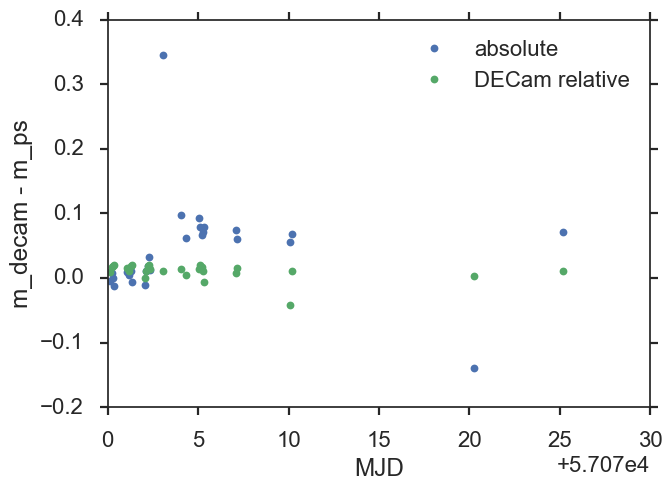

In [767]:
print np.argmin(dif_rel_decam_ps)
print epochs_g[24]
plt.figure(figsize=(7,5))
plt.plot(epochs_g[:,1], dif_decam_ps, 'b.', label='absolute')
plt.plot(epochs_g[:,1], dif_rel_decam_ps, 'g.', label='DECam relative')
plt.legend()
plt.xlabel('MJD')
plt.ylabel('m_decam - m_ps')
plt.show()

## LC test

In [616]:
other_xy_pos = [[1244,179],[1367,1829],[659,3647],[1297,2850],[1356,3955], [1014,562]]
other_xy_pos = np.array(other_xy_pos, dtype=int)

In [617]:
print zp_rel_ps_all[0][0]

25.110583873


In [634]:
rrlyr_lc = []
for rrlyr in other_xy_pos:
    print rrlyr
    lc = []
    
    for kk,epo in enumerate(epochs_g):
        print '  Epoch:',  epo[0],
        if afluxes[kk] == None: continue

        tree = KDTree(cata_epochs[kk][['X_IMAGE', 'Y_IMAGE']].values)
        idx = tree.query_radius(rrlyr.reshape(1, -1), 2)[0]
        print '\t', idx
        if len(idx)==0: continue
            
        print afluxes[kk][0], zp_rel_ps_all[kk][0]
        
        flux_auto = cata_epochs[kk]['FLUX_AUTO'][idx].values[0]
        fluxerr_auto = cata_epochs[kk]['FLUXERR_AUTO_COR'][idx].values[0]
        
        #m_rel_decam = -2.5*np.log10(flux_auto) + \
        #               2.5*np.log10(EXP_TIME) + 2.5*np.log10(afluxes[kk][0]) - \
        #               Ag - info[kk]['AIRMASS']*Kg
        m_rel_decam = cata_epochs[kk]['MAG_AUTO_ZACI'][idx].values[0]
        m_rel_ps = -2.5*np.log10(flux_auto) + \
                    2.5*np.log10(EXP_TIME) + 2.5*np.log10(afluxes[kk][0]) + \
                    zp_rel_ps_all[kk][0]
        m_ps = -2.5*np.log10(flux_auto) + 2.5*np.log10(EXP_TIME) + zp_ps_all[kk][0]
        
        e_m_rel_decam = cata_epochs[kk]['MAGERR_AUTO_ZACI'][idx].values[0]
        e_m_rel_ps = np.sqrt((2.5*fluxerr_auto/(flux_auto*np.log(10)))**2 + \
                             (2.5*afluxes[kk][1]/(afluxes[kk][0]*np.log(10)))**2 + \
                             (zp_rel_ps_all[kk][1])**2)
        e_m_ps = np.sqrt((2.5*fluxerr_auto/(flux_auto*np.log(10)))**2 + \
                             (zp_ps_all[kk][1])**2)
        
        lc.append([float(epo[1]), m_rel_decam, m_rel_ps, m_ps,
                   e_m_rel_decam, e_m_rel_ps, e_m_ps])
    
    df_lc = pd.DataFrame(np.array(lc), columns=['MJD', 'MAG_REL_DECam',
                                                'MAG_REL_PS', 'MAG_PS',
                                                'MAGERR_REL_DECam',
                                                'MAGERR_REL_PS', 'MAGERR_PS'])
    
    rrlyr_lc.append(df_lc)
    #break
        

[1244  179]
  Epoch: 02 	[70]
1 25.110583873
  Epoch: 03 	[47]
1.01474876402 25.1106236132
  Epoch: 04 	[37]
0.982294691072 25.1162440728
  Epoch: 05 	[42]
0.912848129871 25.1248769043
  Epoch: 07 	[29]
0.939596494478 25.0984566304
  Epoch: 08 	[82]
0.975285733343 25.1232830204
  Epoch: 09 	[70]
0.986955516889 25.116226106
  Epoch: 10 	[80]
1.00806247114 25.1146926522
  Epoch: 11 	[16]
0.908111992741 25.1312007158
  Epoch: 12 	[42]
0.92514360849 25.1048182472
  Epoch: 14 	[40]
0.922626026461 25.1119793038
  Epoch: 15 	[39]
0.929052791335 25.1057495294
  Epoch: 16 	[50]
0.986246899791 25.1184237466
  Epoch: 17 	[44]
1.00487208735 25.1141610047
  Epoch: 18 	[55]
0.964827396252 25.1249703243
  Epoch: 19 	[1]
0.901621395738 25.1221261166
  Epoch: 22 	[39]
0.855379979979 25.1093828737
  Epoch: 23 	[36]
0.800044412565 25.1118196142
  Epoch: 25 	[14]
0.86186567172 25.1004037834
  Epoch: 26   Epoch: 27 	[0]
0.855818989874 25.0960854154
  Epoch: 30 	[32]
0.867942436257 25.1150488033
  Epoch: 31

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


  Epoch: 32 	[496]
0.965895626645 25.1056780212
  Epoch: 33 	[517]
0.946301365076 25.1090803148
  Epoch: 34 	[355]
0.85755690542 25.1096061858
  Epoch: 36 	[404]
0.930828433572 25.1136203362
  Epoch: 37 	[566]
0.972163949011 25.1036035467
  Epoch: 39 	[253]
0.959085671927 25.1029875047
  Epoch: 40 	[282]
0.967143113752 25.1064217063
[ 659 3647]
  Epoch: 02 	[1381]
1 25.110583873
  Epoch: 03 	[1230]
1.01474876402 25.1106236132
  Epoch: 04 	[1148]
0.982294691072 25.1162440728
  Epoch: 05 	[1086]
0.912848129871 25.1248769043
  Epoch: 07 	[1010]
0.939596494478 25.0984566304
  Epoch: 08 	[1740]
0.975285733343 25.1232830204
  Epoch: 09 	[1656]
0.986955516889 25.116226106
  Epoch: 10 	[1790]
1.00806247114 25.1146926522
  Epoch: 11 	[1051]
0.908111992741 25.1312007158
  Epoch: 12 	[807]
0.92514360849 25.1048182472
  Epoch: 14 	[951]
0.922626026461 25.1119793038
  Epoch: 15 	[918]
0.929052791335 25.1057495294
  Epoch: 16 	[1196]
0.986246899791 25.1184237466
  Epoch: 17 	[1182]
1.00487208735 25.

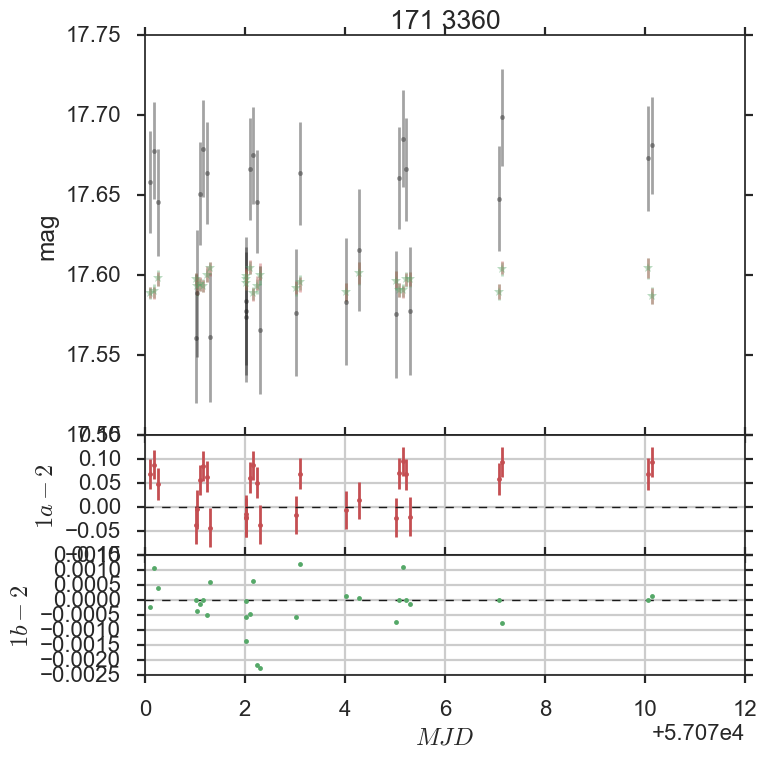

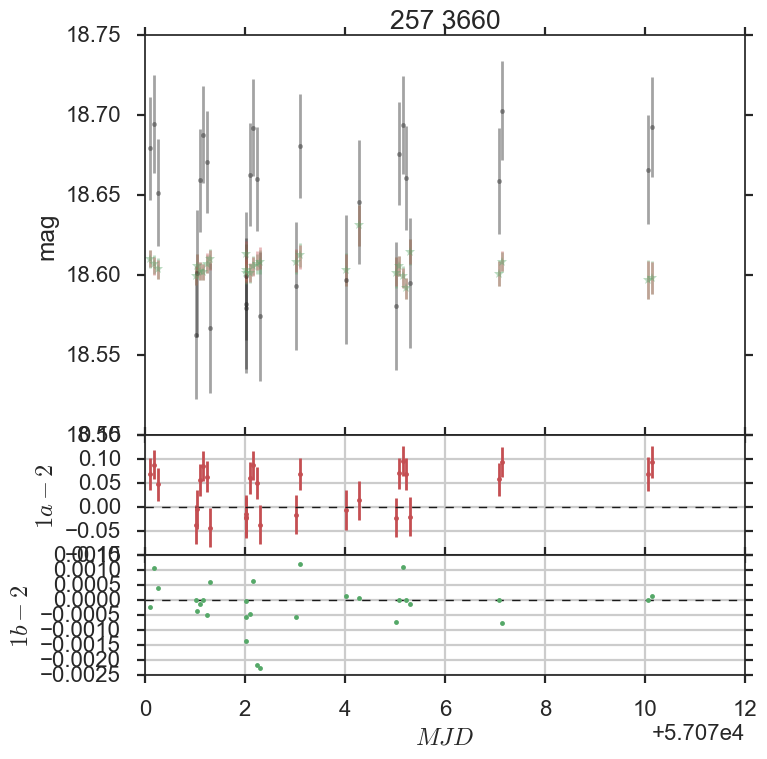

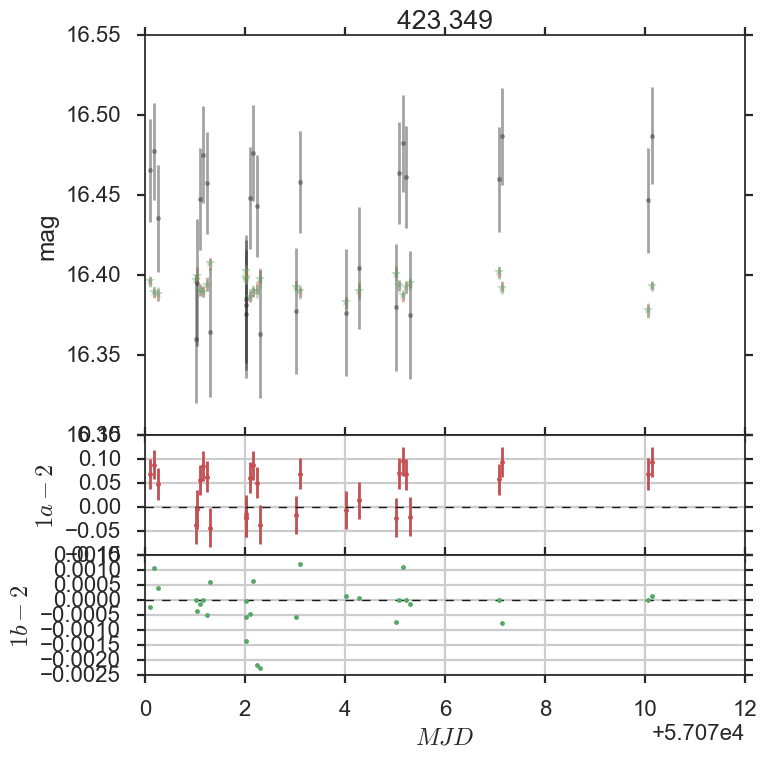

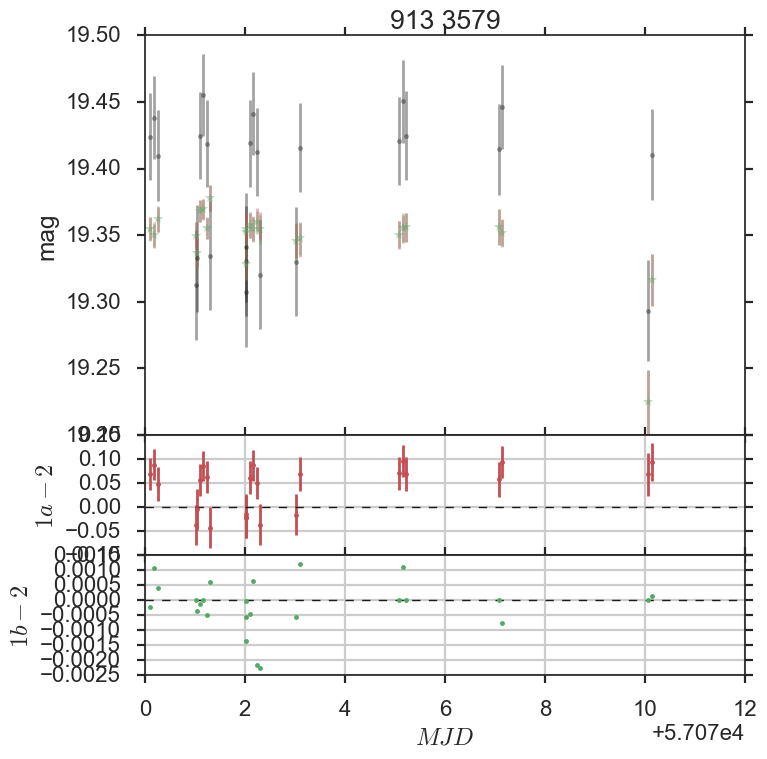

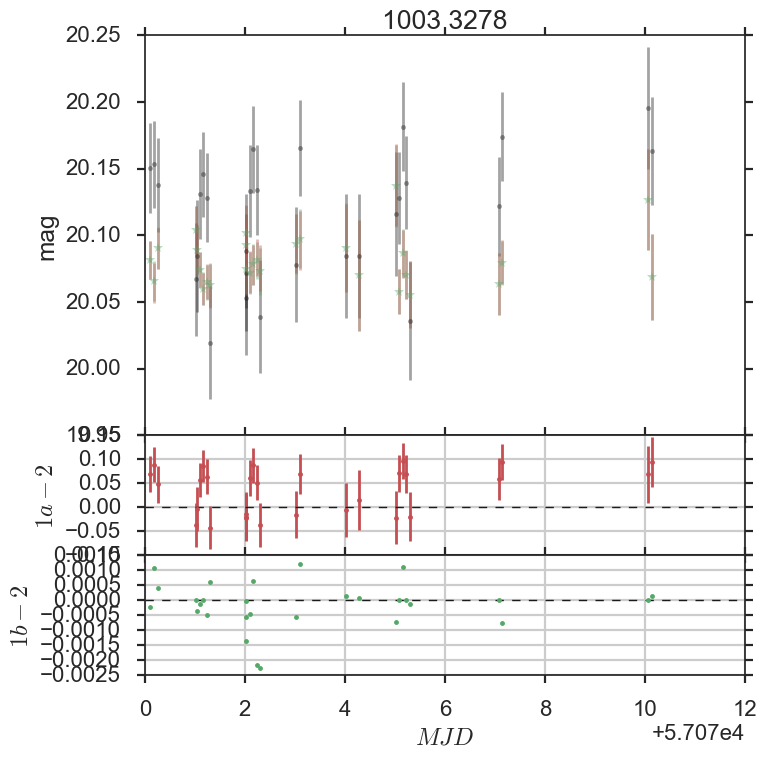

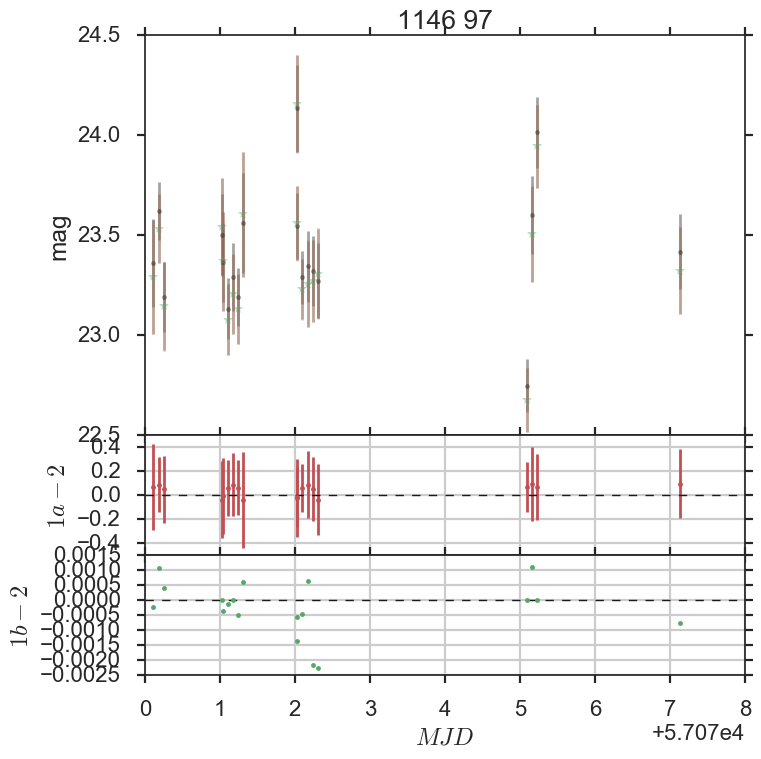

In [635]:
for kk,lc in enumerate(rrlyr_lc):
    fig1 = plt.figure(figsize=(6,4))
    frame2 = fig1.add_axes((0.,.6,1.,1.))
    plt.title('%i %i' % (rrlyr_xy_pos[kk,0],rrlyr_xy_pos[kk,1]))
    plt.errorbar(lc.MJD, lc.MAG_REL_DECam, yerr=lc.MAGERR_REL_DECam, 
                 fmt='.', c='k', alpha=.4, ms=7, lw=2, label='REL+ZP_DECam')
    plt.errorbar(lc.MJD, lc.MAG_REL_PS, yerr=lc.MAGERR_REL_PS, 
                 fmt='*', c='g', alpha=.4, ms=7, lw=2, label='REL+ZP_PS')
    plt.errorbar(lc.MJD, lc.MAG_PS, yerr=lc.MAGERR_PS, 
                 fmt='x', c='r', alpha=.4, ms=7, lw=2, label='ZP_PS')
    plt.ylabel(r'mag')
    frame2.set_xticklabels([])
    
    frame1 = fig1.add_axes((0.,.3,1.,.3))  
    plt.axhline(0, c='k', ls='--', lw=1)
    plt.errorbar(lc.MJD, lc.MAG_REL_DECam - lc.MAG_PS, 
                 yerr=np.sqrt(lc.MAGERR_REL_DECam**2 + lc.MAGERR_PS**2), fmt='.', c='r', ms=7, lw=2)
    plt.legend()
    plt.ylabel(r'$1a - 2$')
    plt.grid()
    frame1.set_xticklabels([])
    
    frame3 = fig1.add_axes((0.,0.,1.,.3))  
    plt.axhline(0, c='k', ls='--', lw=1)
    plt.plot(lc.MJD, lc.MAG_REL_PS - lc.MAG_PS, 'g.', ms=7)
    #plt.errorbar(lc.MJD, lc.MAG_REL_PS - lc.MAG_PS, 
    #             yerr=np.sqrt(lc.MAGERR_REL_PS**2 + lc.MAGERR_PS**2), fmt='.', c='g', ms=7, lw=2)
    plt.legend()
    plt.xlabel(r'$MJD$')
    plt.ylabel(r'$1b - 2$')
    plt.grid()
    plt.show()
    
    #break

In [528]:
AIRMASS = 1.5
mean_color = 0.4
delta_mag2 = (err_Ag)**2 + (AIRMASS*err_Kg)**2 + (err_bg*mean_color)**2
print delta_mag2, np.sqrt(delta_mag2)

0.00287661627881 0.0536340962337
